In [1]:
import numpy as np
# from Scripts.DataManager.DabasePreparations.AmazonReviewSentiGraph import AmazonReviewSentiGraph
# from Scripts.Models.ModelsManager.SimpleGraphClassifierModelManager import SimpleGraphClassifierModelManager
from Scripts.Configs.ConfigClass import Config
config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from lightning.pytorch.loggers import CSVLogger
import os
# os.environ['TORCH_USE_CUDA_DSA']
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = 'cuda'
batch_size = 16

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
test_type = TextGraphType.CO_OCCURRENCE | TextGraphType.DEPENDENCY | TextGraphType.SEQUENTIAL
print((TextGraphType.CO_OCCURRENCE in test_type), (TextGraphType.DEPENDENCY in test_type), (TextGraphType.SEQUENTIAL in test_type), (TextGraphType.TAGS in test_type))
test_type = test_type - (TextGraphType.TAGS | TextGraphType.CO_OCCURRENCE)
print((TextGraphType.CO_OCCURRENCE in test_type), (TextGraphType.DEPENDENCY in test_type), (TextGraphType.SEQUENTIAL in test_type), (TextGraphType.TAGS in test_type))

True True True False
False True True False


In [3]:
from Scripts.DataManager.GraphLoader.AmazonReviewGraphDataModule import AmazonReviewGraphDataModule

In [4]:
tag_dep_seq = TextGraphType.DEPENDENCY | TextGraphType.TAGS | TextGraphType.SEQUENTIAL
data_manager = AmazonReviewGraphDataModule(config, True, True, shuffle=True, num_data_load = 200, device='cpu', batch_size=batch_size, graph_type=tag_dep_seq, load_preprocessed_data = False)

self.num_data_load: 200
i: 0
i: 100


In [5]:
t_dataloader = data_manager.train_dataloader()
v_dataloader = data_manager.val_dataloader()

In [6]:
X1, y1 = next(iter(t_dataloader))
X2, y2 = next(iter(v_dataloader))

In [12]:
# import spacy
# nlp = spacy.load("en_core_web_trf")
# for label in nlp.get_pipe("tagger").labels:
#     print(label, " -- ", spacy.explain(label))

In [13]:
# torch.max(X1['dep'].x)

In [14]:
# X1.edge_attr_dict

In [15]:
X1

HeteroDataBatch(
  dep={
    x=[720, 300],
    batch=[720],
    ptr=[17]
  },
  word={
    x=[1210, 300],
    batch=[1210],
    ptr=[17]
  },
  tag={
    x=[800, 300],
    batch=[800],
    ptr=[17]
  },
  general={
    x=[16, 300],
    batch=[16],
    ptr=[17]
  },
  (dep, dep_word, word)={
    edge_index=[2, 1129],
    edge_attr=[1129]
  },
  (word, word_dep, dep)={
    edge_index=[2, 1129],
    edge_attr=[1129]
  },
  (tag, tag_word, word)={
    edge_index=[2, 1210],
    edge_attr=[1210]
  },
  (word, word_tag, tag)={
    edge_index=[2, 1210],
    edge_attr=[1210]
  },
  (word, seq, word)={
    edge_index=[2, 2388],
    edge_attr=[2388]
  },
  (general, general_word, word)={
    edge_index=[2, 1210],
    edge_attr=[1210]
  },
  (word, word_general, general)={
    edge_index=[2, 1210],
    edge_attr=[1210]
  }
)

In [16]:
from torch import nn, Tensor
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, BatchNorm, SAGEConv
class HeteroGCNConv(nn.Module):
    def __init__(self, in_feature, out_feature, dropout = 0.57) -> None:
        super().__init__()
        self.conv1 = GATv2Conv(in_feature, out_feature, edge_dim=1, add_self_loops=False)
        self.conv2 = GATv2Conv(out_feature, out_feature, edge_dim=1, add_self_loops=False)
        
        self.batch_norm = BatchNorm(out_feature)
        self.dropout= nn.Dropout(dropout)
        
    def forward(self, x: Tensor, edge_index: Tensor, edge_weights: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index, edge_attr=edge_weights))
        x = self.conv2(x, edge_index, edge_attr=edge_weights)
        x = self.batch_norm(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

In [17]:
# len(X1)

In [18]:
from torch_geometric.nn import to_hetero
hetero_model = to_hetero(HeteroGCNConv(300, 256, 0.2), X1.metadata())
pre = hetero_model(X1.x_dict, X1.edge_index_dict, X1.edge_attr_dict)

In [19]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch import Tensor
import torch
from typing import Dict
import torch_geometric
from torch.nn import Linear
from torch_geometric.nn import GATv2Conv, GCNConv, GCN2Conv, DenseGCNConv, dense_diff_pool, BatchNorm, global_mean_pool, global_add_pool, global_max_pool, MemPooling, SAGEConv, to_hetero, HeteroBatchNorm
from torch_geometric.nn import Sequential as GSequential
from torch_geometric.utils import to_dense_adj
from torch import nn, Tensor
import torch.nn.functional as F
from torch_geometric.data import HeteroData

class HeteroGcnGatModel1(torch.nn.Module):
    def __init__(self,
                 input_feature: int, out_features: int,
                 metadata,
                 base_hidden_feature: int=256,
                 dropout=0.1):
        
        super(HeteroGcnGatModel1, self).__init__()
        self.input_features = input_feature
        self.num_out_features = out_features
        self.bsh: int = base_hidden_feature
        bsh2: int = int(self.bsh/2)
        bsh4: int = int(self.bsh/4)
        bsh8: int = int(self.bsh/8)
        
        self.encoder = GSequential('x_dict, edge_index_dict, edge_weights_dict', [
            (to_hetero(HeteroGCNConv(input_feature, self.bsh, dropout), metadata), 'x_dict, edge_index_dict, edge_weights_dict ->x1'),
            (to_hetero(HeteroGCNConv(self.bsh, self.bsh, dropout), metadata), 'x1, edge_index_dict, edge_weights_dict ->x1'),
            (to_hetero(HeteroGCNConv(self.bsh, bsh2, dropout), metadata), 'x1, edge_index_dict, edge_weights_dict -> x2'),
            (to_hetero(HeteroGCNConv(bsh2, bsh2, dropout), metadata), 'x2, edge_index_dict, edge_weights_dict -> x2'),
            (to_hetero(HeteroGCNConv(bsh2, bsh4, dropout), metadata), 'x2, edge_index_dict, edge_weights_dict -> x3'),
            (to_hetero(HeteroGCNConv(bsh4, bsh4, dropout), metadata), 'x3, edge_index_dict, edge_weights_dict -> x3'),
            (to_hetero(HeteroGCNConv(bsh4, bsh8, dropout), metadata), 'x3, edge_index_dict, edge_weights_dict -> x4'),
            (to_hetero(HeteroGCNConv(bsh8, bsh8, dropout), metadata), 'x4, edge_index_dict, edge_weights_dict -> x4'),
            (lambda x1, x2, x3, x4: (x1, x2, x3, x4), 'x1, x2, x3, x4 -> x1, x2, x3, x4')
        ])
        
        print(f'bsh8: {bsh8}')
        self.attention = GSequential('x3, x4, edge_index, edge_weights', [
            (GATv2Conv(bsh8, bsh8, 2, edge_dim=1, dropout=dropout), 'x4, edge_index, edge_weights ->x4'),
            (BatchNorm(bsh4), 'x4->x4'),
            (nn.ReLU(), 'x4->x4'),
            
            (GCN2Conv(bsh4, 0.5, 0.1, 2), 'x4, x3, edge_index, edge_weights->x3'),
            (BatchNorm(bsh4), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            (GCNConv(bsh4, bsh4), 'x3, edge_index, edge_weights -> x3'),
            (BatchNorm(bsh4), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            
            (GATv2Conv(bsh4, bsh4, 2, edge_dim=1, dropout=dropout), 'x3, edge_index, edge_weights ->x3'),
            (BatchNorm(bsh2), 'x3->x3'),
            (nn.ReLU(), 'x3->x3'),
            (lambda x3, x4: (x3, x4), 'x3, x4 -> x3, x4')
        ])
        
        self.decoder = GSequential('x1, x2, x3, edge_index, edge_weights', [
            
            (GCN2Conv(bsh2, 0.5, 0.1, 2), 'x3, x2, edge_index, edge_weights->x2'),
            (BatchNorm(bsh2), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            (GCNConv(bsh2, bsh2), 'x2, edge_index, edge_weights -> x2'),
            (BatchNorm(bsh2), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            (GCNConv(bsh2, self.bsh), 'x2, edge_index->x2'),
            (BatchNorm(self.bsh), 'x2->x2'),
            (nn.ReLU(), 'x2->x2'),
            (nn.Dropout(dropout), 'x2->x2'),
            
            (GCN2Conv(self.bsh, 0.5, 0.1, 2), 'x2, x1, edge_index, edge_weights->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1'),
            (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
            (BatchNorm(self.bsh), 'x1->x1'),
            (nn.ReLU(), 'x1->x1'),
            (nn.Dropout(dropout), 'x1->x1')
        ])
        self.mem_pool = MemPooling(self.bsh, bsh2, 4, 2)
        self.output_layer = Linear(self.bsh, self.num_out_features)
        
        
    def forward(self, x: HeteroData) -> Tensor:
        
        x1_dict, x2_dict, x3_dict, x4_dict = self.encoder(x.x_dict, x.edge_index_dict, x.edge_attr_dict)
        x_att, x4 = self.attention(x3_dict["word"], x4_dict["word"], 
                                   x.edge_index_dict[('word', 'seq', 'word')],
                                   x.edge_attr_dict[('word', 'seq', 'word')])
        x_dec = self.decoder(x1_dict["word"], x2_dict["word"], x_att, 
                             x.edge_index_dict[('word', 'seq', 'word')],
                             x.edge_attr_dict[('word', 'seq', 'word')])
        x_pooled, S = self.mem_pool(x_dec, x['word'].batch)
        x_pooled = x_pooled.view(x_pooled.shape[0], -1)
        
        return self.output_layer(x_pooled)

In [20]:
torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 1024, dropout=0.2)
torch_model = torch_model.to(device)
# print(next(iter(torch_model.parameters())).device)
# pre = torch_model(X1.to(device))

bsh8: 128


In [21]:
import torch
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

torch.cuda.memory_allocated: 0.290503GB
torch.cuda.memory_reserved: 0.302734GB
torch.cuda.max_memory_reserved: 0.302734GB


In [22]:
# from Scripts.Models.BaseModels.GcnGatModel1 import GcnGatModel1
from Scripts.Models.LightningModels.LightningModels import BinaryLightningModel
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner

In [23]:
callbacks = [
    ModelCheckpoint(save_top_k=2, mode='max', monitor='val_acc', save_last=True),
    EarlyStopping(patience=50, mode='max', monitor='val_acc')
]

In [30]:
lightning_model = BinaryLightningModel(torch_model,
                                 torch.optim.Adam(torch_model.parameters(), lr=0.0001, weight_decay=0.00055),
                                       torch.nn.BCEWithLogitsLoss(),
                                       learning_rate=0.0001,
                                       batch_size=batch_size,
                                       ).to(device)

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [31]:
trainer = L.Trainer(
            callbacks=callbacks,
            max_epochs=50,
            accelerator='gpu',
            logger=CSVLogger(save_dir='logs/', name='GcnGatSentiment3'),
            num_sanity_val_steps=0)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
tuner = Tuner(trainer)
results = tuner.lr_find(lightning_model, datamodule=data_manager, min_lr=0.000001,max_lr=0.01)

bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 2.7542287033381663e-06
Restoring states from the checkpoint path at c:\Users\fardin\Projects\ColorIntelligence\.lr_find_aed3c806-4c95-4e27-9cec-1ed57db0884d.ckpt
Restored all states from the checkpoint at c:\Users\fardin\Projects\ColorIntelligence\.lr_find_aed3c806-4c95-4e27-9cec-1ed57db0884d.ckpt


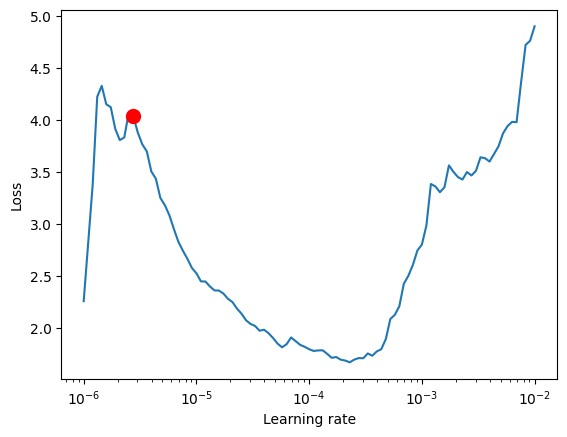

In [29]:
fig = results.plot(suggest=True)

In [32]:
# trainer.fit(lightning_model, datamodule=data_manager)
trainer.fit(lightning_model,
            datamodule=data_manager
            # train_dataloaders=data_manager.train_dataloader(),
            # val_dataloaders=data_manager.val_dataloader(),
            # logger=CSVLogger(save_dir='logs/', name='sample_model'),
            # default_root_dir="~/Desktop"
            )

bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 77.9 M
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
77.9 M    Trainable params
0         Non-trainable params
77.9 M    Total params
311.728   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:58: Detected KeyboardInterrupt, attempting graceful shutdown...


In [33]:
import matplotlib.pyplot as plt
import pandas as pd
'''From torch lightning tutorials'''
def plot_csv_logger(csv_path, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
    metrics = pd.read_csv(csv_path)
    
    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)
    
    df_metrics = pd.DataFrame(aggregation_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
    plt.show()
    

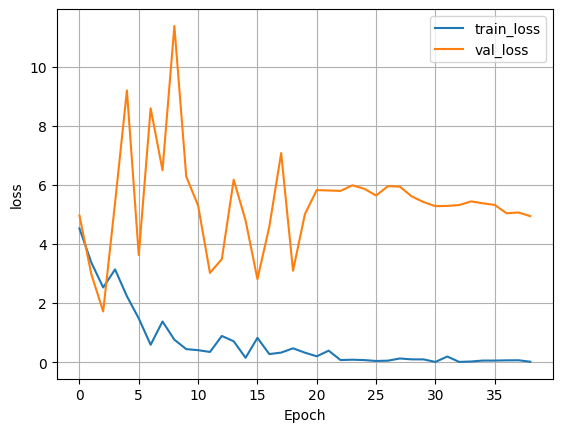

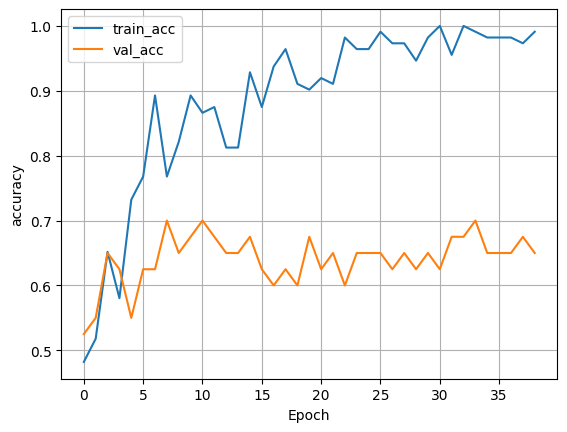

In [35]:
plot_csv_logger(r'C:\Users\fardin\Projects\ColorIntelligence\logs\GcnGatSentiment3\version_12\metrics.csv')